In [372]:
def read_file(file):
    x = open(file,'r', encoding = 'utf-8')
    y = x.read()
    content = y.splitlines()
    return content

chat = read_file('_chat.txt') #ruta donde esté el archivo

In [373]:
type(chat)

list

Tenemos un lista, pero necesitamos pre procesarla para luego armar nuestro DataFrame <br>
Cada entrada viene dada de la siguiente manera:
> __[Fecha Hora] Nombre: mensaje__

__Aclaración:__ El formato puede llegar a variar según el idioma y la versión que tengan.


In [374]:
import datetime

for i in range(len(chat)):
    chat[i] = chat[i].strip('\u200e') 
    chat[i] = chat[i].replace('[','') #eliminamos '['
    chat[i] = chat[i].replace(']','|') #reemplazamos ']' por '|' para usarlo como separador
    try:
        datetime.datetime.strptime(chat[i].split('|')[0], '%d/%m/%y %H:%M:%S') #Convertimos las fechas a un objeto datetime
    
# Para los mensajes largos que tienen mas de una entrada, como no empiezan con la fecha,
# los agregamos a la entrada anterior y eliminamos esa. 
    except ValueError:
        chat[i-1] = chat[i-1] + ' ' + chat[i]     
        chat[i] = "NA"

for i in range(len(chat)):
    if chat[i].split(' ')[0] == 'NA':
        chat[i] = 'NA'
    
while True:
    try:
        chat.remove("NA")
    except ValueError:
        break

Generamos las primeras features para luego armar el DataFrame.<br>
Anteriormente reemplazamos '[ ]' por '|'. Vamos a usar esto ahora para poder separar los atributos, usando la lógica de comprensión de lista

In [375]:
fecha = [datetime.datetime.strptime(text.split(' ')[0], '%d/%m/%y') for text in chat] 
hora = [chat[i].split('|')[0].split(' ')[1] for i in range(len(chat))]
nombre = [chat[i].split('|')[1].split(':')[0].lstrip() for i in range(len(chat))]
mensaje = []
for i in range(len(chat)):
  try:
    mensaje.append(chat[i].split('|')[1].split(':')[1].strip('\u200e'))
  except IndexError:
    mensaje.append('Texto Faltante') #son acciones, como por ejemplo cambiar el nombre del grupo

In [376]:
import pandas as pd
df = pd.DataFrame(list(zip(fecha, hora, nombre, mensaje)), columns = ['Fecha', 'Hora', 'Nombre', 'Mensaje'])

Dentro de los mensajes, podemos ver que el contenido multimedia se ha omitido, por ejemplo tenemos los siguientes mensajes:

In [377]:
[txt for txt in df['Mensaje'] if (txt.endswith('omitida') or txt.endswith('omitido'))][:10]

[' \u200eTarjeta de contacto omitida',
 ' \u200eTarjeta de contacto omitida',
 ' \u200eimagen omitida',
 ' \u200eaudio omitido',
 ' \u200esticker omitido',
 ' \u200eimagen omitida',
 ' \u200eimagen omitida',
 ' \u200eimagen omitida',
 ' \u200eaudio omitido',
 ' \u200eVideo omitido']

Esto nos sirve para saber por ejemplo, el tipo de contenido que se ha enviado.<br>
Para esto nos quedamos solo con la parte que nos interesa y lo incorporamos a nuesto df.

In [378]:
df['Media'] = [txt.replace('omitido','').replace('omitida','').split()[-1].strip('\u200e') if (txt.endswith('omitida') or txt.endswith('omitido')) else None for txt in df['Mensaje'] ]
#eliminamos las palabras omitido u omitida y nos quedamos con la ultima palabra del texto, que es el tipo de contenido

In [379]:
df['Media'].value_counts()

imagen       3212
sticker      2345
audio        1289
Video         893
GIF            99
contacto       24
documento      23
Name: Media, dtype: int64

In [380]:
df['Mensaje'] = [txt.lstrip() for txt in df['Mensaje']] #eliminar espacios iniciales
df['Caracteres']=[len(txt) for txt in df['Mensaje']] #contamos la cantidad de caracteres de cada mensajes
df['Periodo'] = [d.year*100+d.month for d in df['Fecha']] #Año y mes del mensaje

import locale
locale.setlocale(locale.LC_TIME, '') #detalle para cambiar el idioma de los días de la semana.
df['Dia'] = [d.strftime('%A') for d in df['Fecha']] #dia de la semana

In [381]:
df = df[df['Mensaje']!='Texto Faltante']

In [382]:
def momento_dia(hora):
    return (
        "madrugada" if 2 <= hora <= 7
        else
        "mañana" if 7 < hora <= 12
        else
        "mediodia" if 12 < hora <= 16
        else
        "tarde" if 16 < hora <= 20
        else
        "noche"
    )

df['Momento_Dia'] = [momento_dia(datetime.datetime.strptime(hora,'%H:%M:%S').hour) for hora in df['Hora']] #aplicamos la funcion a cada valor

Para hacer públicos los datos en este ejemplo, vamos a ocultar los nombres reales del chat reemplazandolos un diccionario de nombres y los mensajes reemplazando las letras por *.<br>
Si fuese para uso personal no es necesario.

In [383]:
miembros = df['Nombre'].unique()
q_miembros = len(miembros)
n_miembros = ['Miembro '+str(n) for n in range(q_miembros)]
Miembros = dict(zip(miembros,n_miembros))

In [384]:
df = df.replace({"Nombre": Miembros})

In [385]:
def ocultar_msg(msg):
    return ''.join(["*" if letter.isalpha() else letter for letter in msg])
df['Mensaje'] = [ocultar_msg(msg) for msg in df['Mensaje']]

Por ultimo, nos puede interesar la relación que existe entre los miembros del grupo.<br> Podemos estima esta relación con un nuevo campo que determine a que miembro está respondiendo en función de su posición. El mensaje posterior no es necesariamente la respuesta a uno anterior, pero si podemos asumir que están interactuando en ese momento. 

In [386]:
import numpy as np
df.reset_index(inplace=True) #ya que borramos filas en el camino
df['Respuesta'] = [df.loc[i-1, 'Nombre'] if i>0 else None for i in range(len(df))]
df['Respuesta'] = np.where(df['Respuesta'] == df['Nombre'],None,df['Respuesta'])

In [387]:
df[-50:-35]

,index,Fecha,Hora,Nombre,Mensaje,Media,Caracteres,Periodo,Dia,Momento_Dia,Respuesta
86318,86469,2020-10-22,13:29:20,Miembro 32,******** ** ***** ***** ** *****,None,32,202010,jueves,mediodia,None
86319,86470,2020-10-22,13:29:24,Miembro 10,******** ** **** *********,None,26,202010,jueves,mediodia,Miembro 32
86320,86471,2020-10-22,13:29:25,Miembro 32,** ***** *** ******* ** ** **** ******,None,38,202010,jueves,mediodia,Miembro 10
86321,86472,2020-10-22,13:29:28,Miembro 23,***** ******,None,12,202010,jueves,mediodia,Miembro 32
86322,86473,2020-10-22,13:29:37,Miembro 22,**** **** **** *** ************* *** *********...,None,112,202010,jueves,mediodia,Miembro 23
86323,86474,2020-10-22,13:29:51,Miembro 23,************ **********************,None,35,202010,jueves,mediodia,Miembro 22
86324,86475,2020-10-22,13:29:56,Miembro 23,****** **** ** ****,None,19,202010,jueves,mediodia,None
86325,86476,2020-10-22,13:29:59,Miembro 23,****,None,4,202010,jueves,mediodia,None
86326,86477,2020-10-22,13:30:01,Miembro 23,*** ******* ******??,None,20,202010,jueves,mediodia,None
86327,86478,2020-10-22,13:30:07,Miembro 22,****,None,4,202010,jueves,mediodia,Miembro 23


Con estos featrues ya podemos comenzar a realizar nuestro análisis..

### Cantidad de Mensajes por Periodo

In [388]:
import matplotlib.pyplot as plt
import seaborn as sns

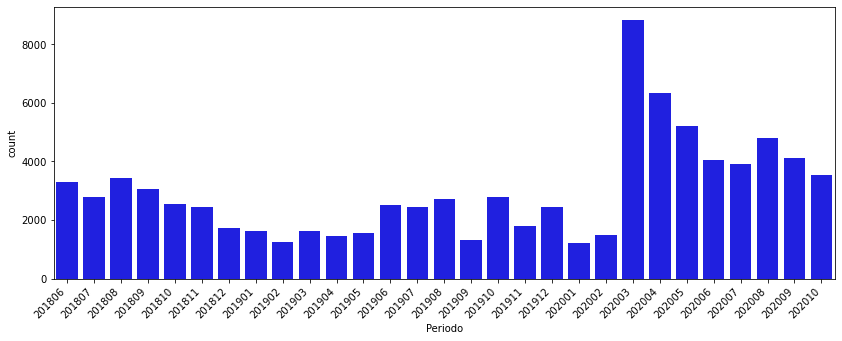

In [389]:
plt.figure(figsize=(14,5))
g = sns.countplot(data= df,x='Periodo', color='blue')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### En qué momentos del día hay mayor actividad?

In [530]:
df2 = df.groupby(['Dia', 'Momento_Dia'])['Dia'].count().unstack('Momento_Dia')
df2["sum"] = df2.sum(axis=1)
df2 = df2.div(df2["sum"], axis=0)

dias = ["lunes","martes","miércoles","jueves","viernes","sábado","domingo"]
momento = ["mañana","mediodia","tarde","noche","madrugada"]
df2=df2.reindex(dias)
df2=df2[momento]

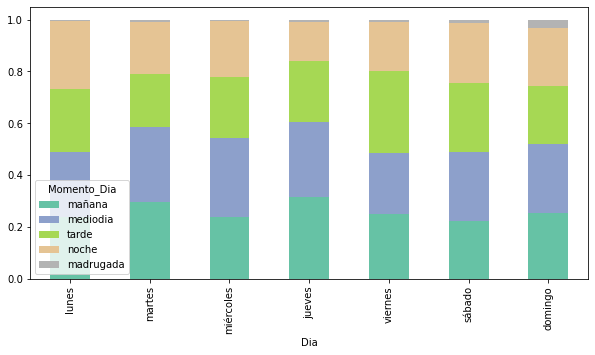

In [538]:
df2.plot(kind='bar', stacked=True,figsize=(10,5),colormap='Set2')
plt.show()

### Los que más stickers enviaron durante 2020.. 

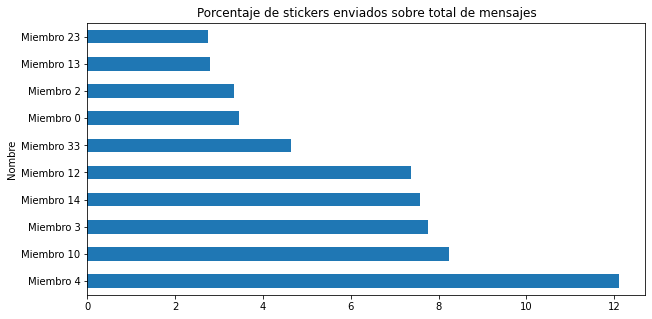

In [524]:
df['s']= df['Media']=='sticker'
s = df[df["Fecha"].dt.year==2020].groupby('Nombre').mean()['s']*100
s = s.sort_values(ascending=False)[:10]
s.plot(kind='barh',title='Porcentaje de stickers enviados sobre total de mensajes',figsize=(10,5))
plt.show()

Se ve que el miembro 4 tiene una importante galeria de stickers. El 12% de sus mensajes son de este tipo.

### Tipo de Contenido por franja horaria 

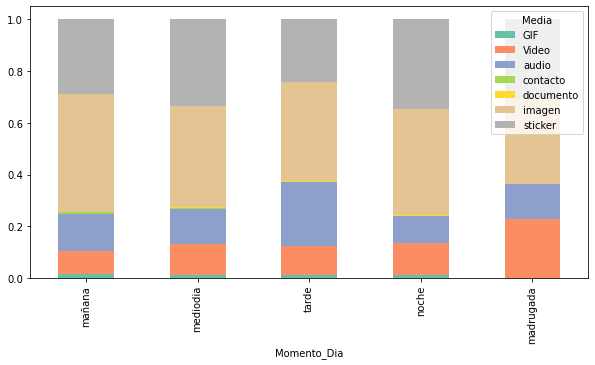

In [537]:
df3 = df.groupby(['Momento_Dia', 'Media'])['Momento_Dia'].count().unstack('Media')
df3["sum"] = df3.sum(axis=1)
df3 = df3.div(df3["sum"], axis=0)
df3.reindex(momento).iloc[:,:-1].plot(kind='bar', stacked=True,figsize=(10,5),colormap='Set2')
plt.show()

Parece que las tardes son mas inspiradoras para enviar audios..